# Bellman's Grid World

This is the general playground to test the Double Conditional Maximum Entropy Inverse Learning (**DECIMEIL**) Algorithm. The premise is a `10 x 10` grid world with various routes starting from different origins `s` and ending at different destinations `g`. 

Each link $i$ has a routing cost, *intrinsic* to the link itself.
$$ c_\theta (i) = f(\text{distance, wind, sector load, airspace charge, convections, (airline preference, source, goal)}) $$

Other consideration: path-overlapping correction term for the logit $\rightarrow$ will be dealt with later when we gradually expand the expressiveness of the cost function.

The goal of **DECIMEIL** is to:
- Learn a discrete choice model that explains the route choice for each flight.
- Adaptable to large scale learning.
- Expandable to neural network based cost approximations.

# Create the grid world and demonstration routes

In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx 
from matplotlib import pyplot as plt 
import numpy as np

Created 4950 edges out of 300 possible edges
NOTICE: The nodes are strings, not integers.


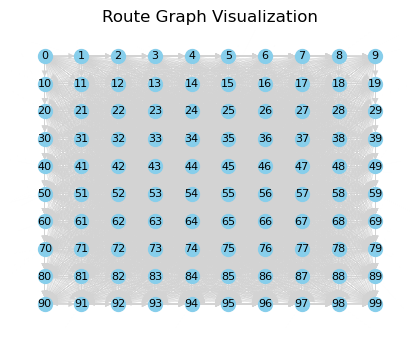

In [2]:
# Create a graph consisting of 100 nodes
# Create a graph with 100 nodes in a 10x10 grid
G = nx.DiGraph()

# Add nodes with attributes
for i in range(100):
    row = i // 10  # Integer division to get row (0-4)
    col = i % 10   # Modulo to get column (0-4)
    G.add_node(str(i), label=i, row=row, col=col, lat=row*0.1, lon=col*0.1)

# Add all possible edges between the 100 nodes (100C2 edges)
for i in range(100):
    for j in range(i+1, 100):  # Start from i+1 to avoid duplicates and self-loops
        # Calculate distance between nodes based on their grid positions
        node_i_row, node_i_col = G.nodes[str(i)]['row'], G.nodes[str(i)]['col']
        node_j_row, node_j_col = G.nodes[str(j)]['row'], G.nodes[str(j)]['col']
        
        # Euclidean distance as edge weight
        distance = np.sqrt((node_i_row - node_j_row)**2 + (node_i_col - node_j_col)**2)
        
        # Add edge with distance as weight
        G.add_edge(str(i), str(j), weight = distance, distance = distance, preference_score = 0.0)

# Print the number of edges to verify
print(f"Created {G.number_of_edges()} edges out of {25*24//2} possible edges")
print(f'NOTICE: The nodes are strings, not integers.')

# Visualize the graph
plt.figure(figsize=(4, 3))

# Get node positions from row and col attributes
pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, font_size=8, edge_color='lightgray', width=0.25)

# Draw edge weights (distances)
# edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Route Graph Visualization")
plt.axis('off')  # Turn off axis
plt.show()

In [3]:
import math
import random

def generate_routes(G, node_ori, node_dest):
    """
    Generate 5 different routes from origin to destination node in the graph.
    
    Args:
        G (networkx.Graph): The graph to search
        node_ori (int): Origin node ID
        node_dest (int): Destination node ID
        
    Returns:
        list: List of 5 different paths, where each path is a list of node IDs
    """
    routes = []
    
    # 1. Shortest path (using Dijkstra's algorithm)
    try:
        shortest_path = nx.shortest_path(G, source=node_ori, target=node_dest, weight='weight')
        routes.append(shortest_path)
    except nx.NetworkXNoPath:
        print(f"No path exists between nodes {node_ori} and {node_dest}")
        return []
    
    # 2. Second shortest path using edge removal technique
    temp_graph = G.copy()
    for i in range(len(shortest_path)-1):
        # Temporarily remove each edge in the shortest path and find alternative
        u, v = shortest_path[i], shortest_path[i+1]
        temp_graph.remove_edge(u, v)
        try:
            alt_path = nx.shortest_path(temp_graph, source=node_ori, target=node_dest, weight='weight')
            if alt_path not in routes:
                routes.append(alt_path)
                break
        except nx.NetworkXNoPath:
            pass
        # Restore the edge for next iteration
        temp_graph.add_edge(u, v, weight=G[u][v]['weight'])
    
    # # 3. Multiple paths with random weights (to encourage diversity)
    # for attempt in range(10):  # Try to generate 3 different paths with random weights
    #     rand_graph = G.copy()
    #     for u, v in rand_graph.edges():
    #         # Add random factor to weights with different randomization each time
    #         rand_factor = 0.3 + random.random() * 1.4  # Wider range for more diversity
    #         rand_graph[u][v]['weight'] = G[u][v]['weight'] * rand_factor
        
    #     try:
    #         rand_path = nx.shortest_path(rand_graph, source=node_ori, target=node_dest, weight='weight')
    #         if rand_path not in routes:
    #             routes.append(rand_path)
    #     except nx.NetworkXNoPath:
    #         continue
    
    # 4. Multiple paths with more nodes (longer but potentially more interesting)
    for attempt in range(10):  # Try different variations of the longer path approach
        long_graph = G.copy()
        for u, v in long_graph.edges():
            # Vary the transformation to get different long paths
            if attempt == 0:
                # Use reciprocal of weight instead of negative log
                long_graph[u][v]['inv_weight'] = 1.0 / (G[u][v]['weight'] + 0.001)  # Add small constant to avoid division by zero
            elif attempt == 1:
                # Reciprocal with random factor
                long_graph[u][v]['inv_weight'] = 1.0 / ((G[u][v]['weight'] * (0.7 + random.random() * 0.6)) + 0.001)
            else:
                # More extreme transformation to prefer even more hops
                long_graph[u][v]['inv_weight'] = 1.0 / ((G[u][v]['weight'] ** 2) + 0.001)
        
        try:
            long_path = nx.shortest_path(long_graph, source=node_ori, target=node_dest, weight='inv_weight')
            if long_path not in routes:
                routes.append(long_path)
        except nx.NetworkXNoPath:
            continue
    
    # 5. A* path with custom heuristic
    def heuristic(u, v):
        # Manhattan distance on the grid
        u_row, u_col = G.nodes[u]['row'], G.nodes[u]['col']
        v_row, v_col = G.nodes[v]['row'], G.nodes[v]['col']
        return abs(u_row - v_row) + abs(u_col - v_col)
    
    a_star_path = nx.astar_path(G, source=node_ori, target=node_dest, 
                                heuristic=heuristic, weight='weight')
    if a_star_path not in routes:
        routes.append(a_star_path)
    
    # If we still need more routes, generate some with random walks
    while len(routes) < 20:
        current = node_ori
        path = [current]
        visited = set([current])
        
        while current != node_dest:
            neighbors = list(G.neighbors(current))
            # Filter out already visited nodes if possible
            unvisited = [n for n in neighbors if n not in visited]
            if not unvisited and not neighbors:
                # Dead end with no way to destination
                break
            if not unvisited:
                # If all neighbors visited, allow revisiting
                unvisited = neighbors
            
            # Choose neighbor that's closer to destination with some randomness
            weights = []
            for n in unvisited:
                # Prefer nodes closer to destination
                n_row, n_col = G.nodes[n]['row'], G.nodes[n]['col']
                dest_row, dest_col = G.nodes[node_dest]['row'], G.nodes[node_dest]['col']
                dist_to_dest = math.sqrt((n_row - dest_row)**2 + (n_col - dest_col)**2)
                # Lower distance gets higher weight
                weights.append(1.0 / (dist_to_dest + 0.1))
            
            # Normalize weights
            total = sum(weights)
            weights = [w/total for w in weights]
            
            next_node = random.choices(unvisited, weights=weights)[0]
            path.append(next_node)
            visited.add(next_node)
            current = next_node
            
            # Prevent infinite loops
            if len(path) > 3 * len(G):
                break
        
        if current == node_dest and path not in routes:
            routes.append(path)
    
    # Ensure we return exactly 10 routes (or fewer if impossible)
    return routes[:20]

In [4]:
def plot_routes(G, routes, node_size=200, route_colors=None, line_width=2, alpha=0.7, probabilities=None):
    """
    Plot multiple routes on the graph, each in its own subplot.
    
    Parameters:
    -----------
    G : networkx.Graph
        The graph containing the nodes and edges
    routes : list of lists
        List of routes, where each route is a list of node IDs
    figsize : tuple, optional
        Figure size (width, height) in inches
    node_size : int, optional
        Size of the nodes in the plot
    route_colors : list, optional
        List of colors for each route. If None, colors will be generated automatically
    line_width : int, optional
        Width of the route lines
    alpha : float, optional
        Transparency of the route lines
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import networkx as nx
    import math
    
    # Calculate grid dimensions
    n_routes = len(routes)
    n_rows, n_cols = 5, 5

    # Automatically determine figure size based on number of routes
    if n_routes <= 4:
        n_rows, n_cols = 2, 2
        figsize = (8, 6)
    elif n_routes <= 9:
        n_rows, n_cols = 3, 3
        figsize = (12, 10)
    elif n_routes <= 16:
        n_rows, n_cols = 4, 4
        figsize = (16, 13)
    else:
        n_rows, n_cols = 5, 5
        figsize = (20, 16)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Get node positions from the graph
    pos = {node: (G.nodes[node]['col'], -G.nodes[node]['row']) for node in G.nodes()}
    
    # Generate colors for routes if not provided
    if route_colors is None:
        # Use a colormap to generate distinct colors
        cmap = plt.cm.rainbow
        route_colors = [cmap(i/n_routes) for i in range(n_routes)]
    
    # Plot each route in its own subplot
    for i, route in enumerate(routes):
        if i >= n_rows * n_cols:
            break  # Don't exceed available subplots
            
        ax = axes[i]
        
        # Draw the graph structure (all nodes and edges)
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=node_size/2, ax=ax)
        # nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, alpha=0.5, ax=ax)
        
        # Draw the route edges
        route_edges = [(route[j], route[j+1]) for j in range(len(route)-1)]
        color = route_colors[i % len(route_colors)]
        
        # Draw the route
        nx.draw_networkx_edges(G, pos, edgelist=route_edges, 
                              edge_color=[color], width=line_width, alpha=alpha, ax=ax)
        
        # Highlight start and end nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[route[0]], 
                              node_color='green', node_size=node_size, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=[route[-1]], 
                              node_color='red', node_size=node_size, ax=ax)
        
        # Add node labels for start and end nodes
        labels = {node: str(node) for node in [route[0], route[-1]]}
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax)
        if probabilities is not None:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}\nProb: {probabilities[i]:.2f}")
        else:
            ax.set_title(f"Route {i}: {route[0]} → {route[-1]}")
        ax.axis('off')
    
    # Hide any unused subplots
    for i in range(n_routes, n_rows * n_cols):
        axes[i].axis('off')
    
    plt.suptitle(f"Graph with {n_routes} routes", fontsize=16)
    plt.tight_layout()
    return fig


## Route Cluster 1: 0 → 24

In [5]:
# Set random seed for reproducibility
import random
random.seed(69420)

routes_0_24 = generate_routes(G, '0', '24')


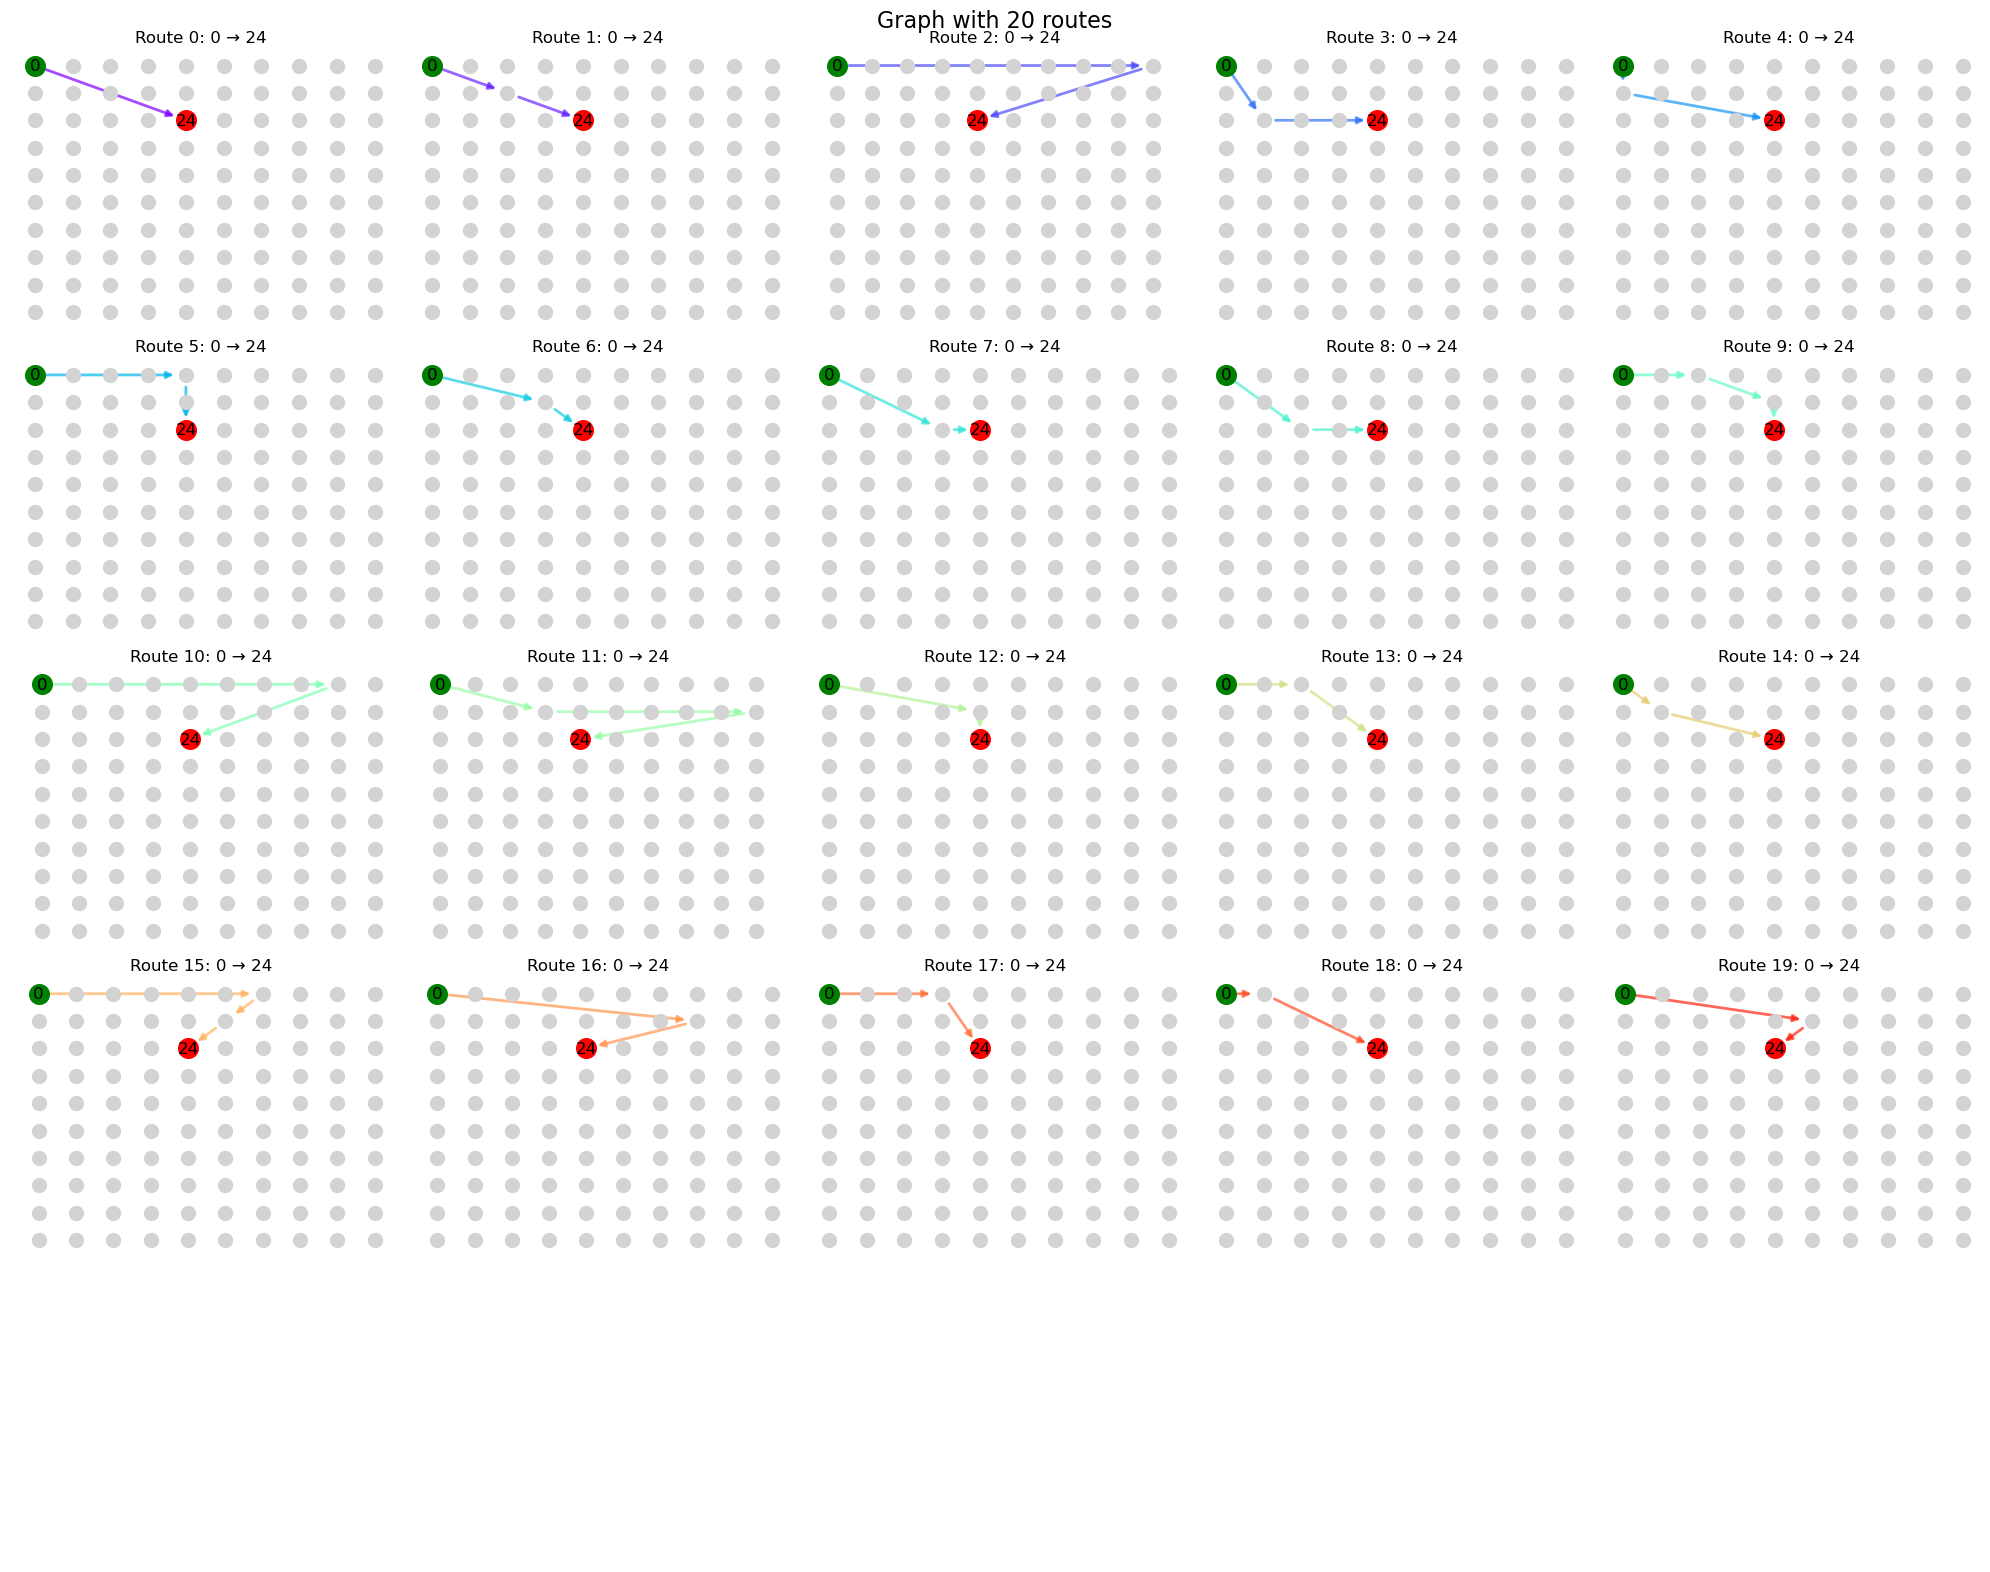

In [6]:
plot_routes(G, routes_0_24)
plt.show()


In [7]:
routes_0_24_final = [routes_0_24[x] for x in [0, 1, 6, 8, 9, 10, 15, 18]]
# Create a random probability distribution for the routes
probabilities = np.random.rand(len(routes_0_24_final))

# Normalize the probabilities to sum to 1
routes_0_24_final_prob = [p / sum(probabilities) for p in probabilities]

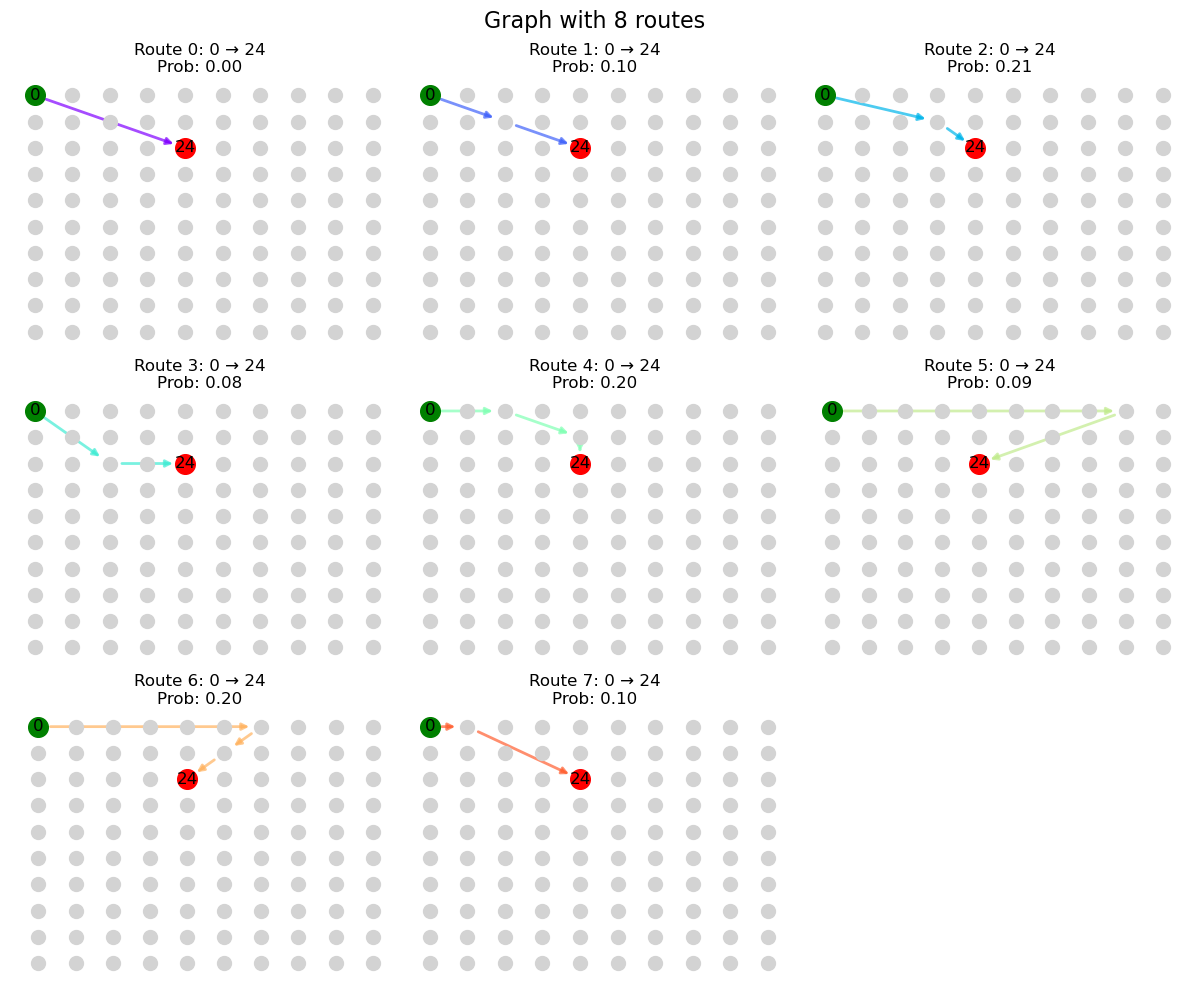

In [8]:
plot_routes(G, routes_0_24_final, probabilities=routes_0_24_final_prob)
plt.show()

# Cost, Adjacency Matrix Computation

In [9]:
from bellman_ford_sparse1100 import compute_edge_costs_dict

costs = compute_edge_costs_dict(G, alpha_pref = 1.0)

In [10]:
from bellman_ford_sparse1100 import graph_to_sparse_matrices
A, C, node_mapping = graph_to_sparse_matrices(G, costs) # note the graph is directional. There are no "going-back" links.
# Check sparsity pattern match
from bellman_ford_sparse1100 import check_sparsity_pattern_match
check_sparsity_pattern_match(A, C)

True

# Value Iterations

## Forward and Backward Value Functions

In [11]:
from bellman_ford_sparse1100 import bellman_fw, bellman_bw
import time 
start_time = time.time()
V_fw = bellman_fw(A, C, 0, max_iter=1000, tol=1e-6, epsilon=1e-10)
V_fw_time = time.time() - start_time
start_time = time.time()
V_bw = bellman_bw(A, C, 24, max_iter=1000, tol=1e-6, epsilon=1e-10)
V_bw_time = time.time() - start_time
print(f'Forward VI time: {V_fw_time:.4f} seconds')
print(f'Backward VI time: {V_bw_time:.4f} seconds')

Forward VI time: 0.0016 seconds
Backward VI time: 0.0013 seconds


## Bellman Forward Validation

We also compute the value function in a more traditional way in order to verify the vectorization trick we used in the `sparse1100` library.

In [12]:
def bellman_fw_verification(graph: nx.DiGraph, costs: dict, 
                           max_iterations: int = 1000, 
                           tolerance: float = 1e-5) -> dict:
    """
    Computes the value function for all nodes using the logsumexp formula:
    V(i) = -log(∑_{k ∈ pred(i)} exp(-weight_of_edge_k - cost(k, i)))
    
    This is a verification function that computes values in a single pass for each node
    based on its predecessors' values.
    
    Parameters:
    -----------
    graph : nx.DiGraph
        The directed graph representing the route network
    
    costs : dict
        Dictionary mapping edge tuples (u, v) to their costs
    
    max_iterations : int, optional (default=1000)
        Maximum number of iterations to perform
    
    tolerance : float, optional (default=1e-5)
        Convergence tolerance
        
    Returns:
    --------
    dict
        Dictionary mapping nodes to their computed value functions
    """
    from scipy.special import logsumexp
    import numpy as np
    
    # Get all nodes in the graph
    nodes = list(graph.nodes())
    
    # Initialize values to infinity
    V = {node: np.inf for node in nodes}
    
    # Find sources (nodes with no incoming edges)
    sources = [node for node in nodes if len(list(graph.predecessors(node))) == 0]
    
    # Initialize source nodes with value 0
    for source in sources:
        V[source] = 0.0
    
    # If no sources found, pick a node and make it the source
    if not sources and nodes:
        V[nodes[0]] = 0.0
    
    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        V_old = V.copy()
        max_delta = 0.0
        
        for node in nodes:
            # Skip source nodes
            if node in sources:
                continue
                
            predecessors = list(graph.predecessors(node))
            if not predecessors:
                continue
                
            # Calculate terms for the logsumexp
            terms = []
            for pred in predecessors:
                edge = (pred, node)
                if edge in costs and np.isfinite(V_old[pred]):
                    # Use the formula V(i) = -log(∑_{k ∈ pred(i)} exp(-weight_of_edge_k - cost(k, i)))
                    terms.append(-costs[edge] - V_old[pred])
            
            # Compute new value with logsumexp
            if not terms:
                new_value = np.inf
            else:
                new_value = -logsumexp(terms)
            
            # Update value and track change
            delta = abs(new_value - V[node])
            max_delta = max(max_delta, delta)
            V[node] = new_value
        
        # Check for convergence
        if max_delta < tolerance:
            # print(f"Bellman-Ford verification converged in {iteration + 1} iterations.")
            return V
    
    # print(f"Warning: Bellman-Ford verification did not converge within {max_iterations} iterations. Max delta: {max_delta}")
    return V

In [13]:
time_start = time.time()
V_fw_test = bellman_fw_verification(G, costs)
time_end = time.time()
print(f'Verification time: {time_end - time_start:.4f} seconds')

Verification time: 0.1851 seconds


In [14]:
V_fw_test_matrix = np.zeros_like(V_fw)
for key, val in V_fw_test.items():
    V_fw_test_matrix[int(key)] = val 

In [15]:
if np.max(np.abs(V_fw - V_fw_test_matrix)) < 1e-3:
    print('\033[92mTwo VI methods arrive at the same result.\nTest passed. ✅\033[0m')
else:
    print('\033[91mTwo VI methods DID NOT arrive at the same result. Something is wrong!\033[0m')

Two VI methods arrive at the same result.
Test passed. ✅


## Bellman Backward Validation

In [16]:
import networkx as nx
from scipy.special import logsumexp
import numpy as np

def bellman_backward_verification(graph: nx.DiGraph, costs: dict, target: any,
                               max_iterations: int = 1000,
                               tolerance: float = 1e-5) -> dict:
    """
    Computes the cost-to-go value function for all nodes using the logsumexp formula:
    V(j) = -log(∑_{i ∈ succ(j)} exp(-cost(j, i) - V(i)))

    This function computes values iteratively starting from the target node
    and propagating backwards.

    Parameters:
    -----------
    graph : nx.DiGraph
        The directed graph representing the transitions. Nodes are keys.
    costs : dict
        Dictionary mapping edge tuples (u, v) to their costs cost(u, v).
    target : any
        The target/goal node, must be a key in the graph nodes.
    max_iterations : int, optional (default=1000)
        Maximum number of iterations to perform.
    tolerance : float, optional (default=1e-5)
        Convergence tolerance.

    Returns:
    --------
    dict
        Dictionary mapping nodes to their computed cost-to-go value functions.
        Nodes that cannot reach the target will have a value of infinity.

    Raises:
    -------
    ValueError
        If the target node is not found in the graph.
    """
    nodes = list(graph.nodes())

    if target not in nodes:
        raise ValueError(f"Target node {target} not found in the graph.")

    # Initialize values to infinity
    V = {node: np.inf for node in nodes}

    # Initialize target node value to 0
    V[target] = 0.0

    # Iterate until convergence or max iterations
    for iteration in range(max_iterations):
        V_old = V.copy()
        max_delta = 0.0

        # Compute new values for all nodes based on V_old
        V_new = {node: np.inf for node in nodes} # Initialize next iteration's values
        V_new[target] = 0.0 # Target value remains 0

        for node in nodes:
            # Skip target node, its value is fixed at 0
            if node == target:
                continue

            successors = list(graph.successors(node))

            # Calculate terms for the logsumexp based on V_old of successors
            terms = []
            for succ in successors:
                edge = (node, succ)
                # Include term if edge exists and successor has finite cost-to-go in V_old
                if edge in costs and np.isfinite(V_old[succ]):
                    # Argument for logsumexp is [-cost(j, i) - V_old(i)]
                    terms.append(-costs[edge] - V_old[succ])

            # Compute new value with logsumexp
            if not terms:
                # If no successors lead to a finite cost path to the target, value remains infinite
                current_new_value = np.inf
            else:
                # V(j) = -log(sum(exp(term_i)))
                current_new_value = -logsumexp(terms)

            V_new[node] = current_new_value

            # Calculate the change compared to the previous iteration's value V_old[node]
            delta = np.inf # Default to infinite change
            if np.isinf(V_old[node]) and np.isinf(current_new_value):
                 delta = 0.0 # No change if both are infinite
            elif not (np.isinf(V_old[node]) or np.isinf(current_new_value)):
                 # Calculate finite change only if both old and new values are finite
                 delta = abs(current_new_value - V_old[node])

            # Track the maximum *finite* change across all nodes for convergence check
            if np.isfinite(delta):
                 max_delta = max(max_delta, delta)

        # Update V for the next iteration
        V = V_new

        # Check for convergence
        if max_delta < tolerance and iteration > 50: # important: we iterate a little longer to ensure convergence
            print(f"Backward Bellman (logsumexp) converged in {iteration + 1} iterations.")
            return V

    # print(f"Warning: Backward Bellman (logsumexp) did not converge within {max_iterations} iterations. Max delta: {max_delta}")
    return V


In [17]:
time_start = time.time()
V_bw_test = bellman_backward_verification(G, costs, '24')
time_end = time.time()
print(f'Verification time: {time_end - time_start:.4f} seconds')

Backward Bellman (logsumexp) converged in 52 iterations.
Verification time: 0.1643 seconds


In [18]:
V_bw_test_matrix = np.zeros_like(V_bw)
for key, val in V_bw_test.items():
    V_bw_test_matrix[int(key)] = val 
if np.max(np.abs(V_bw[np.isfinite(V_bw) & np.isfinite(V_bw_test_matrix)] - V_bw_test_matrix[np.isfinite(V_bw) & np.isfinite(V_bw_test_matrix)])) < 1e-3:
    print('\033[92mTwo VI methods arrive at the same result.\nTest passed. ✅\033[0m')
else:
    print('\033[91mTwo VI methods DID NOT arrive at the same result. Something is wrong!\033[0m')

Two VI methods arrive at the same result.
Test passed. ✅


**<font color="green">All the tests appear to pass: the logsumexp vectorization trick worked marvelously, reducing computational speed by 10x.</font>**

# Double Conditioned Value Function

Value Functions (Lower is Better)


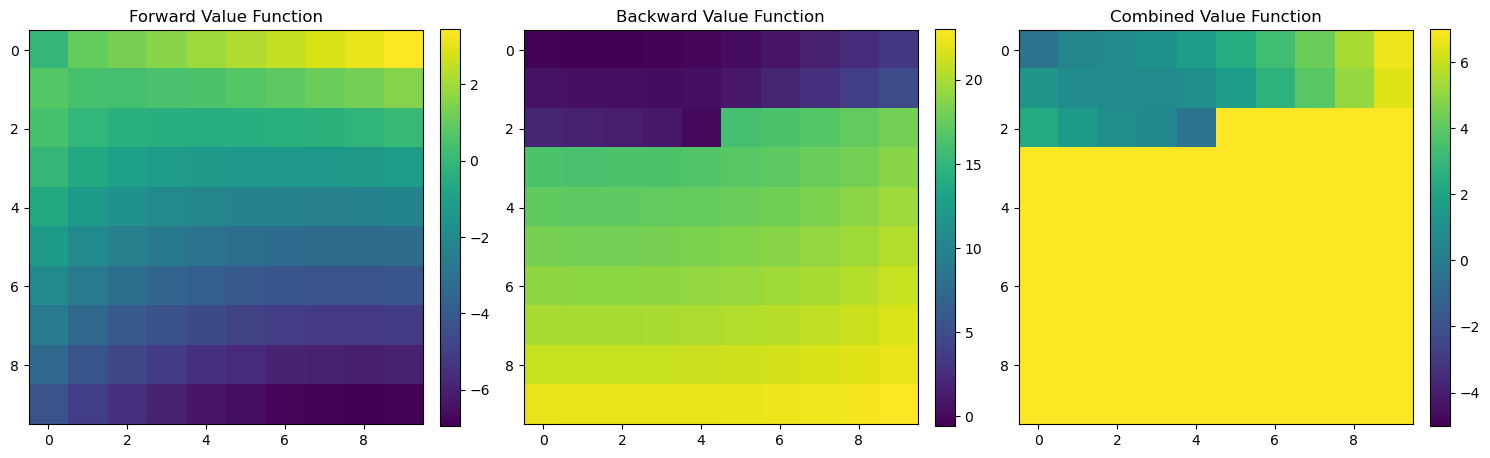

In [19]:
print('Value Functions (Lower is Better)')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
im1 = plt.imshow(V_fw.reshape(10, 10), cmap='viridis')
plt.title('Forward Value Function')
plt.colorbar(im1, fraction=0.046, pad=0.04)

plt.subplot(1, 3, 2)
im2 = plt.imshow(V_bw.reshape(10, 10), cmap='viridis')
plt.title('Backward Value Function')
plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.subplot(1, 3, 3)
U = V_fw + V_bw
im3 = plt.imshow(U.reshape(10, 10), cmap='viridis', vmin=-5, vmax=7)
plt.title('Combined Value Function')
plt.colorbar(im3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# Edge Transition Probabilities

In [21]:
from bellman_ford_sparse1100 import compute_edge_transition_probabilities
Pe_csr = compute_edge_transition_probabilities(A, C, V_fw, V_bw)
Pe = Pe_csr.toarray()

In [33]:
for i in range(25):
    if i == 0:
        cout = 0
    else:
        cout = costs[('0', str(i))]
    
    lt = - (V_fw[0] + cout + V_bw[i])
    print(f'{i}: V_fw = {V_fw[0]}, V_bw = {V_bw[i]}, cost = {cout}, lt = {lt}')

0: V_fw = 0.0, V_bw = -0.4440237188334438, cost = 0, lt = 0.4440237188334438
1: V_fw = 0.0, V_bw = -0.5518284633827732, cost = 1.0, lt = -0.44817153661722675
2: V_fw = 0.0, V_bw = -0.5499240662632272, cost = 2.0, lt = -1.4500759337367728
3: V_fw = 0.0, V_bw = -0.44360433528395304, cost = 3.0, lt = -2.556395664716047
4: V_fw = 0.0, V_bw = -0.20308223392595073, cost = 4.0, lt = -3.796917766074049
5: V_fw = 0.0, V_bw = 0.21142908045166717, cost = 5.0, lt = -5.211429080451667
6: V_fw = 0.0, V_bw = 0.7874581802436323, cost = 6.0, lt = -6.7874581802436325
7: V_fw = 0.0, V_bw = 1.482923056322844, cost = 7.0, lt = -8.482923056322845
8: V_fw = 0.0, V_bw = 2.282602185443592, cost = 8.0, lt = -10.282602185443592
9: V_fw = 0.0, V_bw = 3.2458136513754026, cost = 9.0, lt = -12.245813651375403
10: V_fw = 0.0, V_bw = 0.5659129030934141, cost = 1.0, lt = -1.5659129030934142
11: V_fw = 0.0, V_bw = 0.3880401303793536, cost = 1.4142135623730951, lt = -1.8022536927524486
12: V_fw = 0.0, V_bw = 0.2828862001

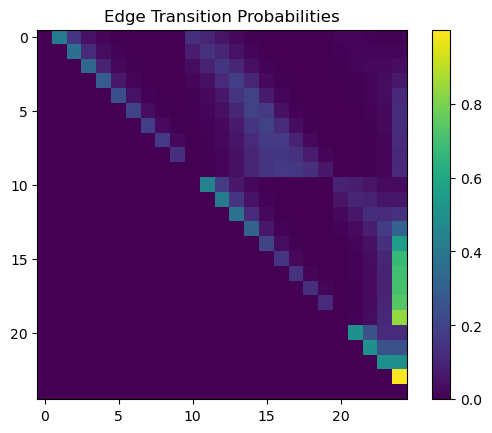

In [22]:
plt.imshow(Pe[0:25, 0:25])
plt.title('Edge Transition Probabilities')
plt.colorbar()
plt.show()


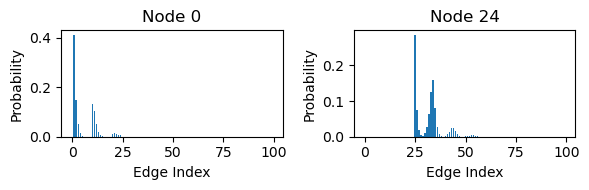

In [23]:
plt.figure(figsize=(6, 2))
plt.subplot(1,2,1)
plt.bar(range(100), Pe[0,:])
plt.title('Node 0')
plt.xlabel('Edge Index')
plt.ylabel('Probability')
plt.subplot(1,2,2)
plt.bar(range(100), Pe[24,:])
plt.title('Node 24')
plt.xlabel('Edge Index')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

In [38]:
from bellman_ford_sparse1100 import compute_expected_traversals
node_traversals, edge_traversals = compute_expected_traversals(Pe_csr, 0, 24)

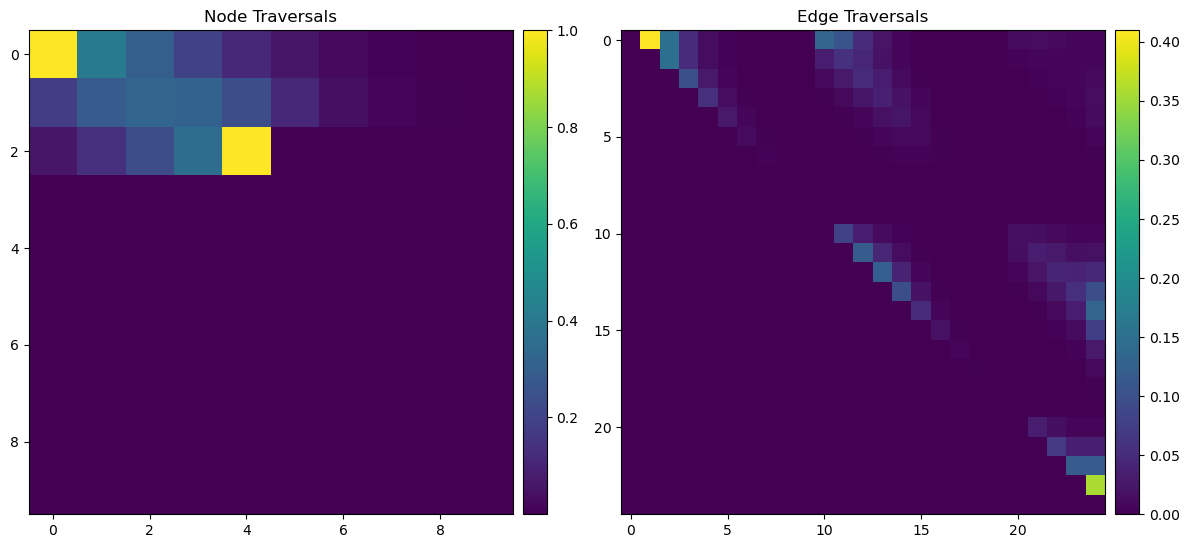

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot (Node Traversals)
im1 = ax1.imshow(node_traversals.reshape((10, 10)))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax1)
ax1.set_title('Node Traversals')

# Second subplot (Edge Traversals)
im2 = ax2.imshow(edge_traversals.toarray().reshape((100, 100))[:25, :25])
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2)
ax2.set_title('Edge Traversals')

plt.tight_layout()
plt.show()


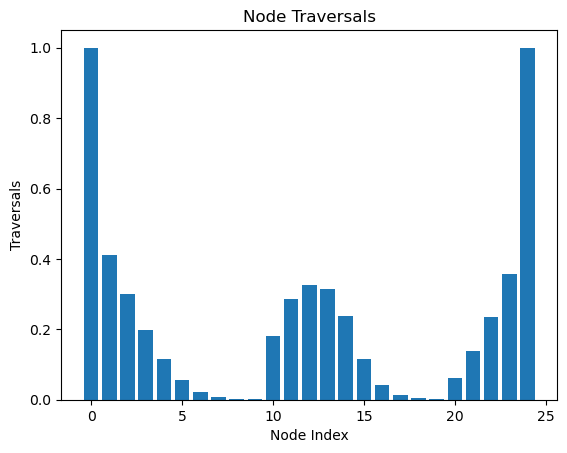

In [52]:
plt.bar(range(25), node_traversals[0:25])
plt.title('Node Traversals')
plt.xlabel('Node Index')
plt.ylabel('Traversals')
plt.show()

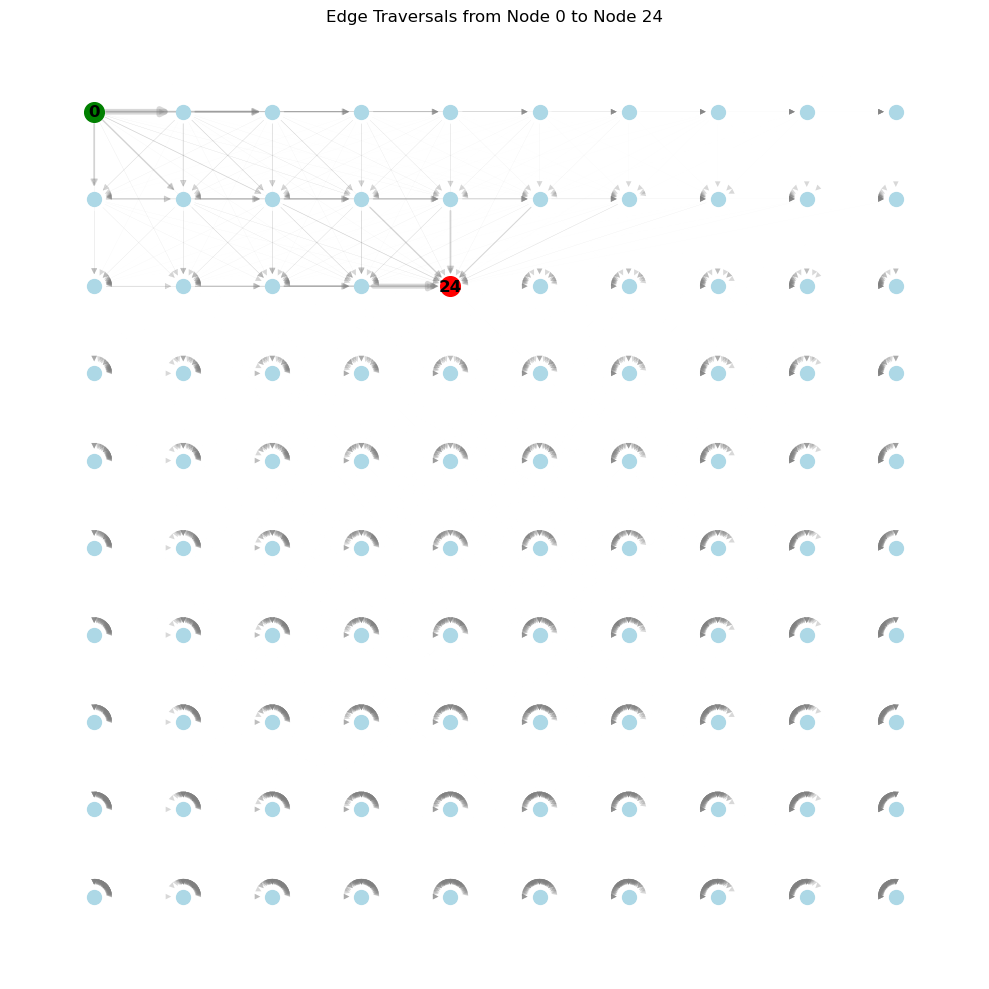

In [47]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Extract the edge traversals data
edge_traversals_array = edge_traversals.toarray()

# Create a new graph for visualization
G_vis = nx.DiGraph()

# Add nodes with positions based on grid layout (10x10 grid)
for i in range(100):
    row, col = i // 10, i % 10
    G_vis.add_node(str(i), pos=(col, 9-row))  # Adjust row to flip y-axis for better visualization

# Add edges with weights from edge_traversals
for i in range(100):
    for j in range(100):
        if edge_traversals_array[i, j] > 0:
            G_vis.add_edge(str(i), str(j), weight=edge_traversals_array[i, j])

# Get positions for all nodes
pos = nx.get_node_attributes(G_vis, 'pos')

# Create figure
plt.figure(figsize=(10, 10))

# Extract the path from node 0 to node 24
path_edges = []
current_node = '0'
target_node = '24'

# Find path with highest traversal weights
while current_node != target_node:
    neighbors = list(G_vis.neighbors(current_node))
    if not neighbors:
        break
    
    # Find neighbor with highest traversal weight
    next_node = max(neighbors, key=lambda n: G_vis[current_node][n]['weight'])
    path_edges.append((current_node, next_node))
    current_node = next_node

# Draw all nodes
nx.draw_networkx_nodes(G_vis, pos, node_size=100, node_color='lightblue')

# Draw all edges with varying width based on traversal weight
edges = G_vis.edges()
weights = [G_vis[u][v]['weight'] * 10 for u, v in edges]  # Scale for better visualization
nx.draw_networkx_edges(G_vis, pos, edgelist=edges, width=weights, alpha=0.3, edge_color='gray')

# Highlight the path from 0 to 24
# if path_edges:
#     path_weights = [G_vis[u][v]['weight'] * 5 for u, v in path_edges]
#     nx.draw_networkx_edges(G_vis, pos, edgelist=path_edges, width=path_weights, 
#                           edge_color='red', arrows=True)

# Highlight start and end nodes
nx.draw_networkx_nodes(G_vis, pos, nodelist=['0'], node_size=200, node_color='green')
nx.draw_networkx_nodes(G_vis, pos, nodelist=['24'], node_size=200, node_color='red')

# Add labels for start and end nodes
nx.draw_networkx_labels(G_vis, pos, labels={'0': '0', '24': '24'}, font_weight='bold')

plt.title('Edge Traversals from Node 0 to Node 24')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot (Forward Value Function)
im1 = ax1.imshow(V_fw.reshape((10, 10)))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax1)
ax1.set_title('Forward Value Function')

# Second subplot (Backward Value Function)
im2 = ax2.imshow(V_bw.reshape((10, 10)))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2)
ax2.set_title('Backward Value Function')

plt.tight_layout()
plt.show()

In [ ]:
V_bw.reshape((10, 10))

## Link Traversal Probabilities 

In [ ]:
from bellman_ford_sparse1100 import compute_edge_probabilities
time_start = time.time()
Pe = compute_edge_probabilities(A, C, V_fw, V_bw)
time_end = time.time()
print(f'Edge probability computation time: {time_end - time_start:.4f} seconds')

In [55]:
Pe = Pe.toarray()

In [ ]:
plt.imshow(Pe)
plt.colorbar()
plt.show()


# QUASAR-R-Zero

- Routing Module
- Zero Edge Dependency

## Gradient Descent with Multiple Restarts for Model Learning

In [ ]:
N_demonstrations = 899
# Sample N_demonstrations routes from routes_0_24_final with probability routes_0_24_final_prob
demonstrations = []
for _ in range(N_demonstrations):
    # Sample a route based on the probability distribution
    sampled_route_idx = random.choices(range(len(routes_0_24_final)), weights=routes_0_24_final_prob, k=1)[0]
    demonstrations.append(routes_0_24_final[sampled_route_idx])

# Count occurrences of each route in demonstrations
route_counts = {}
for route in demonstrations:
    route_tuple = tuple(route)  # Convert list to tuple for hashing
    if route_tuple in route_counts:
        route_counts[route_tuple] += 1
    else:
        route_counts[route_tuple] = 1

# Print statistics about the sampled demonstrations
print(f"Sampled {N_demonstrations} demonstrations")
print("Route distribution in demonstrations:")
for route_tuple, count in route_counts.items():
    percentage = (count / N_demonstrations) * 100
    print(f"Route {list(route_tuple)}: {count} occurrences ({percentage:.2f}%)")

In [ ]:
from bellman_ford import optimize_preferences_with_restarts

GX = G.copy()

start_node = '0'
target_node = '24'
alpha = 1.0       # Weight for preference score in cost
alpha_r = 0.01    # Regularization strength (L2)
learning_rate = 0.25 # Step size for gradient descent
num_epochs = 10_000    # Number of optimization iterations
initial_preference = 0.0 # Initial guess for preference scores
convergence_threshold = 1e-5 # Stop if max gradient component is small

optimized_graph, history = optimize_preferences_with_restarts(
        graph=GX,
        demonstrations=demonstrations,
        start_node=start_node,
        target_node=target_node,
        alpha=alpha,
        alpha_r=alpha_r,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        initial_preference=initial_preference,
        convergence_threshold=convergence_threshold,
        early_stopping_patience=1000,
        init_std=3.0,
        num_restarts=3
    )

## Inspection of Results

In [24]:
from dotenv import load_dotenv
load_dotenv()

import os 

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
# Add PROJECT_ROOT to Python search path 

import sys 
sys.path.append(PROJECT_ROOT)

In [25]:
from bellman_ford import calculate_edge_costs

def add_edge_cost_to_graph(graph, alpha = 1.0):
    # Calculate costs using the existing function and preferences from optimized_graph
    costs = calculate_edge_costs(graph, alpha)
    return_graph = graph.copy()

    # Add costs as a property to each edge in the graph
    for (u, v), cost in costs.items():
        return_graph.edges[u, v]['cost'] = cost
    return return_graph

optimized_graph_with_costs = add_edge_cost_to_graph(optimized_graph)

In [ ]:
for edge in optimized_graph_with_costs.edges():
    print(f'Edge {edge}: DIST = {optimized_graph_with_costs.edges[edge]["distance"]:.2f} PREF = {optimized_graph_with_costs.edges[edge]["preference_score"]:.2f} COST = {optimized_graph_with_costs.edges[edge]["cost"]:.2f}')

In [ ]:
from bellman_ford import calculate_empirical_visitations, calculate_expected_visitations, soft_bellman_ford, calculate_transition_probs
ED = calculate_empirical_visitations(G, demonstrations)
print(f'Empirical Visitation Distribution:')
for edge, count in ED.items():
    print(f'Edge {edge}: Visits={count}')


print(f'---')
print(f'Model Visitation Distribution:')
costs = calculate_edge_costs(optimized_graph_with_costs, alpha)
V_soft = soft_bellman_ford(optimized_graph_with_costs, target_node, costs)

# 3. Calculate transition probabilities
transition_probs = calculate_transition_probs(optimized_graph_with_costs, costs, V_soft)

# 4. Calculate expected state and edge visitations
D, E_pi = calculate_expected_visitations(optimized_graph_with_costs, start_node, target_node, transition_probs)
for edge, expected_visitation in E_pi.items():
    print(f'Edge {edge}: Visits={expected_visitation}')

## Sampling from the new graph

In [ ]:
# Sample 1000 routes from the optimized graph 

import lateral.planner_pivot_with_heuristics_lean_fix1100 as mcmc
MAX_ITER = 10_000
BURN_IN = 5_000 # can go as high as 10_000
THINNING = 50 # can go as high as 50 
sampled_routes = []
temperature = 1.0

total_accepted = 0

# Find the shortest path between 0 and 24
# shortest_path = nx.shortest_path(G, source='0', target='24', weight='weight')
shortest_path = ['0', '12', '24']
print(f'Shortest path: {shortest_path}')
route = shortest_path 

import time 
start_time = time.time()
for i in range(MAX_ITER):
    new_route, accepted = mcmc.mcmc_step(optimized_graph_with_costs, route, temperature = 10.0, verbose = False,
                                    max_depth=8, collapse_pivot=False)
    
    print(f'{i < BURN_IN and "Burn-in" or "Sampling"} | Iteration {i+1}, accepted: {total_accepted}               ', end='\r')
    
    if accepted:
        route = new_route
        
    if i > BURN_IN: # Sampling phase
        if accepted:
            total_accepted += 1
        if i % THINNING == 0:
            sampled_routes.append(route)
        
print(f"Total chain time: {time.time() - start_time:.2f} seconds. Total accepted: {total_accepted}/{MAX_ITER - BURN_IN}")


In [29]:
def compute_route_probabilities(sampled_routes):
    # Count occurrences of each unique route
    route_counts = {}
    for route in sampled_routes:
        # Convert list to tuple to make it hashable for dictionary keys
        route_tuple = tuple(route)
        route_counts[route_tuple] = route_counts.get(route_tuple, 0) + 1
    
    # Calculate total number of routes
    total_routes = len(sampled_routes)
    
    # Calculate probability for each unique route
    route_probabilities = {route: count / total_routes 
                           for route, count in route_counts.items()}
    
    return route_probabilities  # or return route_probabilities if you prefer tuples

sampled_routes_proba = compute_route_probabilities(sampled_routes)

In [ ]:
# Extract keys (routes) and values (probabilities) from the dictionary
unique_routes = list(sampled_routes_proba.keys())
route_probabilities = list(sampled_routes_proba.values())

# Convert tuple routes back to lists if needed
unique_routes = [list(route) for route in unique_routes]

# Plot with the extracted data
plot_routes(G, unique_routes, probabilities=route_probabilities)
plt.show()

For debugging:

In [ ]:
from bellman_ford import calculate_empirical_visitations, calculate_expected_visitations, soft_bellman_ford, calculate_transition_probs
ED = calculate_empirical_visitations(G, demonstrations)
print(f'Empirical Visitation Distribution:')
for edge, count in ED.items():
    print(f'Edge {edge}: Visitation={count}')


print(f'---')
print(f'Model Visitation Distribution:')
costs = calculate_edge_costs(optimized_graph_with_costs, alpha)
V_soft = soft_bellman_ford(optimized_graph_with_costs, target_node, costs)

# 3. Calculate transition probabilities
transition_probs = calculate_transition_probs(optimized_graph_with_costs, costs, V_soft)

# 4. Calculate expected state and edge visitations
D, E_pi = calculate_expected_visitations(optimized_graph_with_costs, start_node, target_node, transition_probs)
for edge, expected_visitation in E_pi.items():
    print(f'Edge {edge}: Visitation={expected_visitation}')

In [ ]:
# Call Bellman-Ford to debug
from bellman_ford import optimize_preferences
_, __ = optimize_preferences(
        graph=GX, # GX and optimized_graph_with_costs are the same graph
        demonstrations=demonstrations,
        start_node=start_node,
        target_node=target_node,
        alpha=alpha,
        alpha_r=alpha_r,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        initial_preference=initial_preference,
        convergence_threshold=convergence_threshold,
        early_stopping_patience=1000,
        infer_mode=True
    )